# ARIMA Modeling

Here we explain ARIMA model by discussing its mathematical functions such as **'AR', 'I'** and **'MA'** in its name.

## AR (Autoregressive)
The autoregressive (AR) component assumes that the current value of series is a linear combination of its previous values. This means the current value is regressed on past values of the same series.

### Equation (1)
$$
y_t = \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + \dots + \alpha_p y_{t-p} + e_t
$$
Where:
- $ \alpha_1, \alpha_2, \dots, \alpha_p $ are the AR parameters.
- $ e_t $ is the error term.
- $ p $ is the lag order, representing how many past values influence the current value.

The integrated (I) component refers to differencing the series to make it stationary, i.e., to remove trends or seasonality. Differencing subtracts the previous observation from the current one.

### Equation (2)
For first-order differencing (d=1):
$$
y_t' = y_t - y_{t-1}
$$
For second-order differencing (d=2):
$$
y_t'' = (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) = y_t - 2y_{t-1} + y_{t-2}
$$
The integer $ d $ denotes the number of times differencing is applied until the series becomes stationary.

## Moving Average (MA)
The moving average component models the dependency between the current value and past errors. It assumes that the current value of the series depends on past forecast errors.

### Equation (3)
$$
y_t = e_t + \beta_1 e_{t-1} + \beta_2 e_{t-2} + \dots + \beta_q e_{t-q}
$$
Where:
- $ \beta_1, \beta_2, \dots, \beta_q $ are the MA parameters.
- $ e_t $ is the error at time $ t $.
- $ q $ is the order of the moving average, indicating how many past errors influence the current value.

## ARIMA (p,d,q) Model
The ARIMA model combines the AR, I, and MA components into a single model.

### Equation (4)
$$
d_t = \alpha_1 d_{t-1} + \alpha_2 d_{t-2} + \dots + \alpha_p d_{t-p} + e_t + \beta_1 e_{t-1} + \dots + \beta_q e_{t-q}
$$
Where:
- $ d_t $ is the differenced series after applying differencing $ d $ times.
- $ \alpha_1, \dots, \alpha_p $ capture the relationship with past values (AR part).
- $ \beta_1, \dots, \beta_q $ capture the relationship with past errors (MA part).

## Fitting an ARIMA Model
To fit an ARIMA model:
1. **Determine $ p $, $ d $, and $ q $:** Use ACF (Auto-correlation Function) and PACF (Partial Auto-correlation Function) plots to decide on the AR and MA orders.
2. **Estimate parameters:** Use Maximum Likelihood Estimation (MLE) to find the best-fitting parameters ($ \alpha $ and $ \beta $).
3. **Model validation:** Perform diagnostic checks, such as residual analysis, to ensure the model fits well.
4. **Forecast:** Use the fitted model to forecast future values.

ARIMA modeling is slow, so we are applying only to monthly downsampled data

**Maximum Likelihood Estimation (MLE) basic:**

Maximum Likelihood Estimation (MLE) is a method of estimating the parameters of a statistical model by maximizing the likelihood function, which represents the probability of the observed data given the parameters. It doesn’t aim to minimize the error (like in least squares), but rather to maximize the probability of the data. It's done using iterative method.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import copy

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('final_data.csv')
df.reset_index(inplace=True)

In [ ]:
df.columns

Index(['index', 'DATE', 'Precip', 'WetBulbTemp', 'DryBulbTemp', 'RelHumidity',
       'WindSpeed', 'StationPressure', 'gauge_height'],
      dtype='object')

<hr>

The standard ARIMA model is use for univariate forecasting. i.e. it uses only one column of data as input.
We will implement ARIMA to make prediction for future values of gauge height based on past values.

We will fit ARIMA model for 1 year of data. ARIMA is a small model and there are few parameters to learn.
One year of data is normally a lot of data. Also note that ARIMA can be slow.

Select data for year 2023 only.

In [3]:
df['DATE'] = pd.to_datetime(df['DATE'])

df_23 = df[df.DATE.dt.year == 2023]

Next select only the gauge height data

In [6]:
df_23_gh = df_23[['DATE', 'gauge_height']]

df_23_gh.set_index('DATE', inplace=True)

In [7]:
df_23_gh

,gauge_height
DATE,
2023-01-01 00:00:00,7.0725
2023-01-01 01:00:00,8.4900
2023-01-01 02:00:00,9.6575
2023-01-01 03:00:00,10.1700
2023-01-01 04:00:00,10.0800
...,...
2023-12-31 19:00:00,4.5350
2023-12-31 20:00:00,4.5400
2023-12-31 21:00:00,4.5275


**Split the data such that, 10 months data is used for training and 2 months data is used for testing**

In [8]:
train, test = df_23_gh[:'2023-11-01 00:00:00'], df_23_gh['2023-11-01 01:00:00':]

In [9]:
# import ARIMA model

from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

Note that p, d and q are the hyperparameters in ARIMA model
- p stands for "sequence length or lookback window or lag"
- q stands for "number of past errors"
- d stands for differencing

Let's train the model with lookback window of 6 hours

In [10]:
# Using 5 hours because it's computationally expensive and slow to use more. But you can try.

ORDER = (2, 1, 2) #lag p=2; difference d=1; error dependency q=2
model = ARIMA(train, order=ORDER, freq='1h')

In [11]:
model_fit = model.fit()

We have fit the ARIMA model, which means we have calculated p(6) parameters that approximate how previous observations affect the next output.
Similary, we have calculated q(6) parameters that approximate how previous errors (predictions) affect the next output.

So, to make new prediction we need 6 previous observations and 6 previous errors.

we trained model for training data, it has a bunch of information it has saved. They can be observed by printing following fields.

In [ ]:
# Data saved in the model

# model_fit.resid  - Pandas Series with date as index : Saved residuals
# model_fit.model.endog - Numpy array 2D array : Saved training data
# model_fit.fittedvalues - Pandas Series with date as index : Fitted (predicted) values from training data
# model_fit.arparams - Numpy array : calculated parameters that determine effect of past values
# model_fit.maparams - Numpy array : calculated parameters that dtermine effect of past errors

<hr>

## Performing forecasting and evaluating the model and outputs.

There are two ways we normally make forecasts in ARIMA.

Forecastd values depend on past observed values, past residuals, and model parameters.
When model is trained, it forecasts values for training data, calculates residuals based on observations and updates model parameters so as to minimize residuals.
For training dataset, we can observe the corresponding training data, fitted values, residuals and computed model parameters in following objects

`model_fit` -- Fitted Model

    - `model_fit.resid`  - Pandas Series with date as index : Saved residuals
    - `model_fit.model.endog` - Numpy array 2D array : Saved training data
    - `model_fit.fittedvalues` - Pandas Series with date as index : Fitted (predicted) values from training data
    - `model_fit.arparams` - Numpy array : calculated parameters that determine effect of past values
    - `model_fit.maparams` - Numpy array : calculated parameters that dtermine effect of past errors

### Making predictions using the trained model
1. Prediction with refitting

In this method, we make forecast for next step using the trained model. Then, when we get the observation for next step, we update the training data with this new observation.
And finally we retrain the model to update the parameters and make prediction for next step.


2. Rolling foreast

In this method, given the test data for next steps, the model makes next prediction, then it dynamically uses the corresponding observaed values from test data, calculates residuals and uses this information to make further predictions.  


In [12]:
# Method 1
predicted_values = []
observed_values = []

history = train.copy()

# This method is slow, we will make prediction for next 20 steps only
test_subset = test[:20]

model_fit1 = copy.deepcopy(model_fit)

for i in range(len(test_subset)):
    # make prediction for next timestep

    prediction = model_fit1.forecast(steps=1)[0]

    idx = test_subset.index[i]

    # observed value at next timestep
    observation = test_subset.iloc[i]

    # update training data
    history.loc[idx] = observation

    model = ARIMA(history, order=ORDER, freq='1h')
    model_fit1 = model.fit()

    predicted_values.append(prediction)
    observed_values.append(observation)
    print(f'{i}/{len(test_subset)} done')


0/20 done
1/20 done
2/20 done
3/20 done
4/20 done
5/20 done
6/20 done
7/20 done
8/20 done
9/20 done
10/20 done
11/20 done
12/20 done
13/20 done
14/20 done
15/20 done
16/20 done
17/20 done
18/20 done
19/20 done


Next, we will perform rolling forecast. In this approach we won't retrain the model each time but provide last observed <br>value to the model in each step.
It updates the previous vaues and residuals but parameters are not updated.

`append` method

"Recreate the results object with new data appended to the original data.
Creates a new result object <br>applied to a dataset that is created by appending new data to the end of the model’s original data. <br>The new results can then be used for analysis or forecasting." **-- from documentation**

### Method 2


In [13]:
# to compare between the results obtained above, we will just compute for 20 steps
# rolling evaluation

# append method documentation
# url: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.append.html


# Method 2
predicted_values2 = []
observed_values2 = []

test_subset = test[:20]

model_fit2 = copy.deepcopy(model_fit)

for i in range(len(test_subset)):
    # make prediction for next timestep

    prediction = model_fit2.forecast(steps=1)[0]

    idx = test_subset.index[i]

    # observed value at next timestep
    observation = test_subset.iloc[i]

    # saved the observed value to the model
    model_fit2 = model_fit2.append([observation], refit=False)

    predicted_values2.append(prediction)
    observed_values2.append(observation)



#prediction_subset = model_fit.predict(start=test_subset.index[0], end=test_subset.index[-1], dynamic=True)

<hr>

Let's calculate how the model did by calculating the metrics. We will compute

- Mean Absolute Error(MAE): Measures the average of absolute differences between predicted and observed values.
$$
\text{MAE} = \frac{1}{n} \sum_{t=1}^{n} |y_t - \hat{y}_t|
$$

- Nash Sutcliffe Efficiency (NSE) Coefficent: Quantifies the average absolute difference between predicted and observed values.
$$
\text{NSE} = 1 - \frac{\sum_{t=1}^{n} (y_t - \hat{y}_t)^2}{\sum_{t=1}^{n} (y_t - \bar{y})^2}
$$

- Weighted Percentage Error (WAPE): Measures prediction accuracy in percentage form, weighted by total observed values.
$$
\text{WAPE} = \frac{\sum |y_t - \hat{y}_t|}{\sum |y_t|} \times 100\%
$$

In [14]:
from sklearn.metrics import mean_absolute_error

import numpy as np

epsilon = np.finfo(float).eps

def WAPE(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    nominator = np.sum(np.abs(np.subtract(y, y_pred)))
    denominator = np.add(np.sum(np.abs(y)), epsilon)
    wape = np.divide(nominator, denominator)*100.0
    return wape

def NSE(y, y_pred):
    return (1-(np.sum((y_pred-y)**2)/np.sum((y-np.mean(y))**2)))

Following method executes the above functions and print results.

Before executing, it's important to make sure that input vectors are 1D numpy arrays.

In [15]:
def evaluate(test_subset, prediction_subset):

    test_subset = np.array(test_subset).flatten()
    prediction_subset = np.array(prediction_subset).flatten()

    mae = mean_absolute_error(test_subset, prediction_subset)
    nse = NSE(test_subset, prediction_subset)
    wape = WAPE(test_subset, prediction_subset)

    print(f'MAE: {mae:.2f}\nNSE: {nse}\nWAPE: {wape}')
    return (nse, mae, wape)

In [16]:
print("Rolling evaluation")  #this is the the better technique (method 2) as it also takes less time
evaluate(observed_values2, predicted_values2)

print("\nRetraining each time")
evaluate(observed_values, predicted_values)

Rolling evaluation
MAE: 0.08
NSE: 0.9187005913943072
WAPE: 1.5836697076317179

Retraining each time
MAE: 0.08
NSE: 0.9186558812984513
WAPE: 1.5840199692984294


(np.float64(0.9186558812984513),
 0.08475892853219733,
 np.float64(1.5840199692984294))

**Here we evaluate the model for all of the test data. (with method 2)**

In [17]:
def make_predictions(test, model):
    predicted_values = []

    for i in range(len(test)):
        # make prediction for next timestep

        prediction = model.forecast(steps=1)[0]

        idx = test.index[i]

        # observed value at next timestep
        observation = test.iloc[i]

        model = model.append([observation], refit=False)

        predicted_values.append(prediction)
        if(i % 100 == 0):
            print(f'{i}/{len(test)} done')

    return predicted_values


predictions = make_predictions(test, copy.deepcopy(model_fit))


0/1463 done
100/1463 done
200/1463 done
300/1463 done
400/1463 done
500/1463 done
600/1463 done
700/1463 done
800/1463 done
900/1463 done
1000/1463 done
1100/1463 done
1200/1463 done
1300/1463 done
1400/1463 done


In [18]:
nse, mae, wape = evaluate(test, predictions)

MAE: 0.04
NSE: 0.9976722732838206
WAPE: 0.7149849940390016


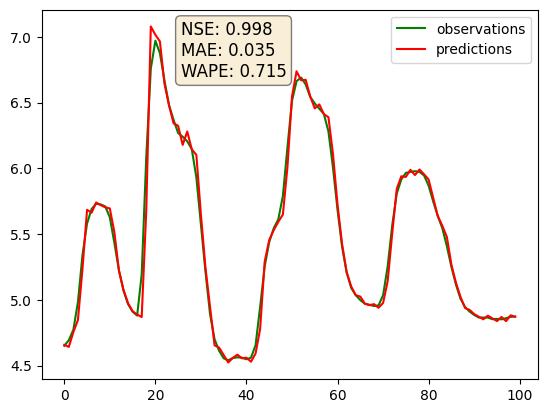

In [19]:
x = range(len(test))

# add evaluation results in the graph itself

plt.plot(np.array(test[:100]), color='green', label='observations')
plt.plot(np.array(predictions[:100]), color='red', linestyle='-', label='predictions')
metrics_text = f"NSE: {nse:.3f}\nMAE: {mae:.3f}\nWAPE: {wape:.3f}"
plt.text(0.28, 0.97, metrics_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.legend()
plt.show()